## LSTM ULMFiT-type approach to time-series forecasting & classification¶
This notebook explores an ULMFiT-type approach to time series classification, wherein a forecaster (
Language model in NLP) is trained on sequential data, then the weights of the encoder and core transferred into a classifier of similar architecture.

The notebook automates preprocess of data on any of the 128 UCR time series classification datasets. Download here: http://www.timeseriesclassification.com/index.php, unzip, and set your pwd there to run this notebook as is.

## Phase 1: Imports, pre-process, and visualization

We define some helper functions that will massage the TSC datasets into a form condusive for training and analysis. Briefly, clean-up & shuffles the data, checks the labels are zero-indexed (for some of the datasets this is not the case which causes CrossEntropyLoss to complain down the line), makes sure the datatypes are correct, and generates a long-form time-series which is condusive for visualization. The rest of the functions are straightforward tools to visualize results. Then we make use of seaborn's time-series plot function to plot out each class one at a time as well as all together so we can get a sense of how easy or difficult this problem looks.

In [1]:
from scipy.io import arff
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pdb
import torch.nn as nn
import torch.nn.functional as F
import torch
import fastai.basic_data
import fastai.basic_train
import fastai.train
from fastai.metrics import accuracy
import warnings
warnings.filterwarnings('ignore')

In [14]:
def load_df(task):
    data = arff.loadarff('NewTSCProblems/%s/%s_TRAIN.arff'%(task,task))
    df = pd.DataFrame(data[0])
    return df
    
def cleanup(df):
    df.columns = [k for k in range(df.shape[1]-1)]+['target']
    for k in df.columns[:-1]:
        df[k] = df[k].astype('float')
    if df.target.dtype == 'object':
        df['target'] = df['target'].apply(lambda x: x.decode('ascii')).astype('int')
    if sorted(df.target.unique()) != list(np.arange(df.target.nunique())):
        new_targs = pd.DataFrame({'target':df.target.unique()}).reset_index()
        df = pd.merge(df, new_targs, left_on='target', right_on='target').drop('target',axis=1).rename(columns={'index':'target'})
    ts = pd.melt(df.reset_index(), id_vars=['index','target'], var_name='time').rename(columns={'index':'id'})
    ts = ts.groupby(['id','time','target']).value.mean().reset_index()
    #df = df.sample(df.shape[0], replace=False).reset_index(drop=True)
    return df, ts

def fetch_predictions(model, ts, df, h=1, output=False):
    data = partial_lm_dataset(df)
    date_range = [k for k in range(h,df.shape[1]-1)]
    dl = DataLoader(data, batch_size=32, shuffle=False)
    pieces = []
    model.cpu()
    model.eval()
    for x,y in dl:
        pieces.append(model(x).detach().numpy())
    pct = pd.DataFrame(np.concatenate(pieces).squeeze())
    pct.index = df.index
    pct = pct.transpose()
    pct['time'] = date_range
    pts = pd.melt(pct, id_vars='time', var_name = 'id', value_name = 'predicted_value')
    pts.id = pts.id.astype('int')
    pts = pd.merge(ts, pts, left_on=['time','id'], right_on=['time', 'id'], how='left').fillna(0)
    return pts

def graph_ts(ts):
    for k in ts.target.unique():
        fig, axes = plt.subplots(figsize=(15,5))
        sns.tsplot(ts[ts.target == k], time='time', unit='id', condition='target', value='value', err_style='unit_traces', ax=axes)    
    fig, axes = plt.subplots(figsize=(15,5))
    sns.tsplot(ts, time='time', unit='id', condition='target', value='value', err_style='unit_traces', ax=axes)
    return None

def graph_predictions(pts, size=5):
    ids = np.random.choice(np.arange(pts.id.nunique()), size=size)
    for k in ids:
        piece = pts[pts.id == pts.id.unique()[k]]
        piece.index = piece.time
        fig,ax = plt.subplots()
        piece.value.plot.line()
        piece.predicted_value.plot.line()
        ax.legend()
    return None

def get_cm(clf, val_dl):
    clf.data.valid_dl = val_dl
    x, y = clf.get_preds()
    preds = torch.max(x, dim=1)[1]
    cm = confusion_matrix(y, preds)
    return cm

In [15]:
task = 'StarLightCurves'
df = load_df(task)
df, ts = cleanup(df)

(1000, 1025)

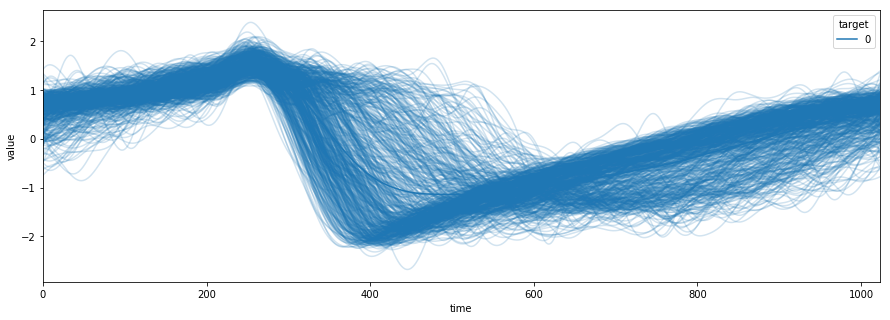

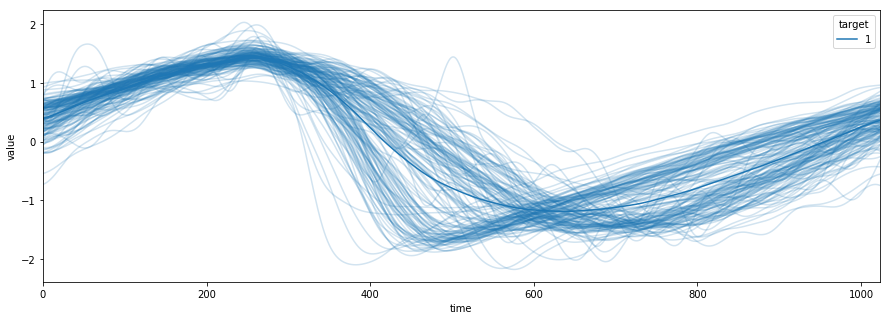

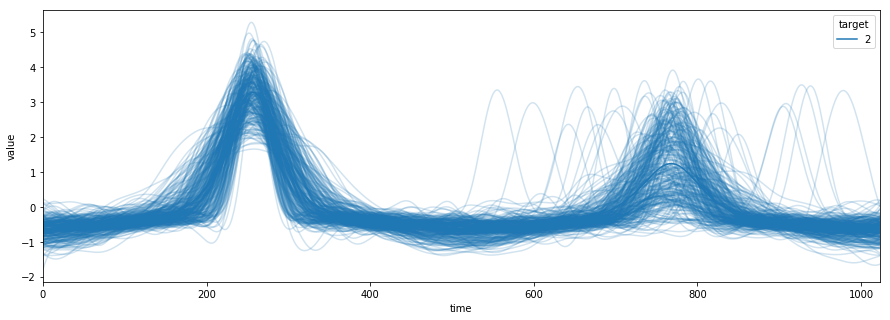

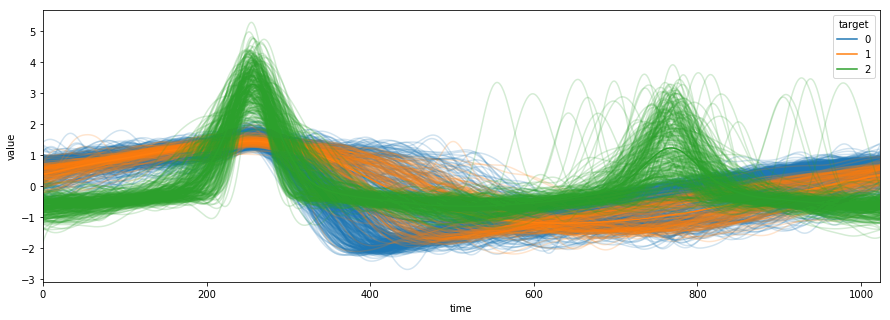

In [4]:
graph_ts(ts); df.shape


## Phase Two: Forecasting
In this section we define our dataset object which can be used to train a forecasting model. A couple comments on the amateurish implementation: bptt should be chosen such that it divides the length of the time-series lest data be thrown away. Also take note that bptt cannot be greater than the length of the time-series or it will throw an error, will fix this later.

We separate validation in two different ways: first we set aside some observations (time-series) that the model will not see at all during training, so we can judge how well the model is capable of generalizing to time-series it hasn't seen before. A quick comment: in some of the TSC datasets there are very few observations, and so choosing the validation obs at random can result in asymmetrical distribution of classes in training vs. validation set. This can be checked with a call to df.target.value_counts() and should be avoided. Furthermore, we set aside some percentage of time-steps (even on the training observations) to judge how well our model is able to generalize out-of-time on time series it has seen as well.

Last comment: I have experienced in the past if the data is very jagged (not smooth, and I've noticed on a lot of these datasets that is the case) then forecasting with RNN tends to be rocky, applying a smoothing technique like exponential smoothing may be helpful.

In [5]:
class partial_lm_dataset(Dataset):
    def __init__(self, ts):
        self.x = torch.stack([torch.Tensor(ts.iloc[k][:-1].values.astype('float')) for k in range(ts.shape[0])], dim=1)
            
    def __len__(self):
        return self.x.size(1)
    
    def __getitem__(self, idx):
        return self.x[:-1,idx].unsqueeze(1), self.x[1:,idx].unsqueeze(1)
    
def fetch_lm_dataset(ts, bptt):
    num_pieces = int((ts.shape[1]-1)/bptt)
    datasets = []
    for j in range(num_pieces):
        cols = [j for j in range(j*bptt, (j+1)*bptt)]
        datasets.append(partial_lm_dataset(ts[cols]))
    ds = ConcatDataset(datasets)
    ds.init_kwargs = None
    return ds

def dropout_mask(x, sz, p):
    return x.new(sz).bernoulli_(1-p).div_(1-p)

class rnn_dropout(nn.Module):
    'Dropout consistent on the time axis'
    def __init__(self, p=0.3):
        super().__init__()
        self.p = p
        
    def forward(self, x):
        if not self.training or self.p == 0 : return x
        m = dropout_mask(x.data, torch.Size((x.size(0), 1, x.size(2))), self.p)
        return m*x

class lm(nn.Module):
    def __init__(self, n_in, nh, n_out, ncl, dp):
        super().__init__()
        self.encode = nn.LSTM(n_in,nh, batch_first=True)
        self.cores = nn.ModuleList([nn.LSTM(nh, nh, batch_first=True) for _ in range(ncl)])
        self.drops = nn.ModuleList([rnn_dropout(dp) for _ in range(ncl)])
        self.decode = nn.Linear(nh, n_out)
        
    def forward(self, x):
        x = self.encode(x)[0]
        for core, drop in zip(self.cores, self.drops):
            x = drop(core(x)[0])
        x = self.decode(x)
        return x

Selecting the bptt is kind of important. I do it by inspection of the time-series you obviously want the window to be large enough to capture high-level adjacent salient features and it really depends from task to task in this repository.

In [17]:
timesteps = df.shape[1]
tr_time = int(timesteps * 0.9)
num_obs = df.shape[0]
tr_obs = int(num_obs*0.8)

#You should check these are kind of even lol
#print(df.iloc[tr_obs:].target.value_counts())
#print(df.iloc[:tr_obs].target.value_counts())

In [18]:
tr_ds = fetch_lm_dataset(df[df.columns[:tr_time]].iloc[:tr_obs], bptt=300)
val_ds = fetch_lm_dataset(df.iloc[tr_obs:], bptt=300)

In [19]:
tr_dl = DataLoader(tr_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)

In [20]:
lm_net = lm(n_in = 1, nh = 256, n_out = 1, ncl = 3, dp = 0.0)
md = fastai.basic_data.DataBunch(tr_dl,val_dl)
crit = nn.MSELoss()
lm_learn = fastai.basic_train.Learner(md, lm_net, loss_func=crit)

In [ ]:
lm_learn.lr_find() ; lm_learn.recorder.plot()

In [21]:
lm_learn.fit_one_cycle(2)

epoch,train_loss,valid_loss
1,0.327823,0.139112
2,0.113333,0.024319


The first of the following three calls picks some obserations at random (train or val) and graphs out the predicted vs. actual values for all time. This is important because if the model cannot even learn the training data it is possible (i) the data is very noisy (ii) there is not enough data (iii) you need to increase complexity or decrease regularization or possibly (iv) your bptt is too short. Either way, if you can't get reasonably good results on training data perhaps LM/forecasting type approach is not well-suited on this problem.

The second call checks training observations but hones in on a period of time the model has not seen, this is important for determining if your model can generalize out-of-time to time-series it has seen.

The third call checks validation observations, this is the most difficult and if you are seeing good (whatever that means) results on this then you are definitely getting along well at this stage!

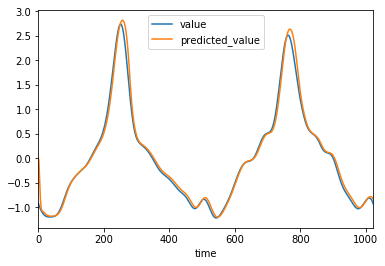

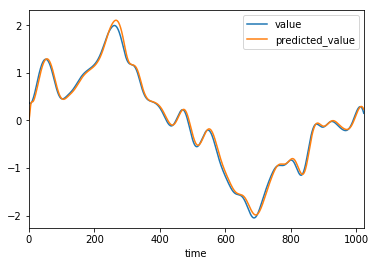

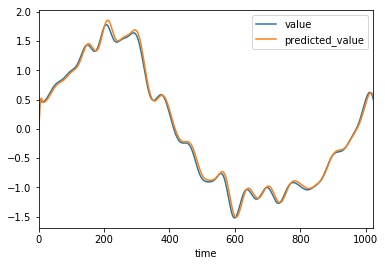

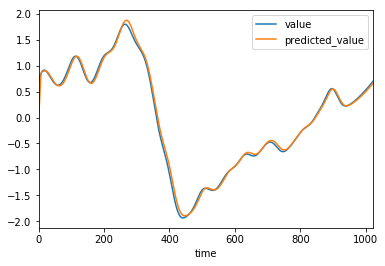

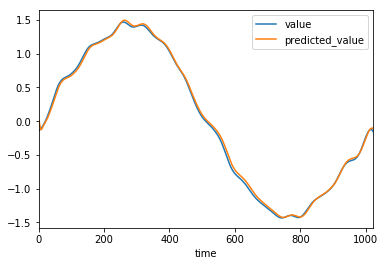

In [22]:
pts = fetch_predictions(lm_learn.model.cpu(), ts, df); graph_predictions(pts, size=5)

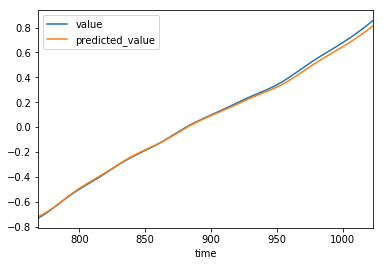

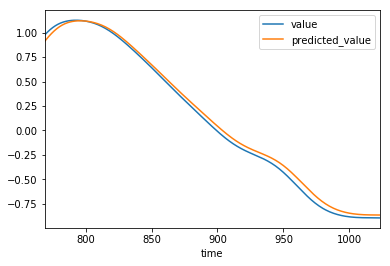

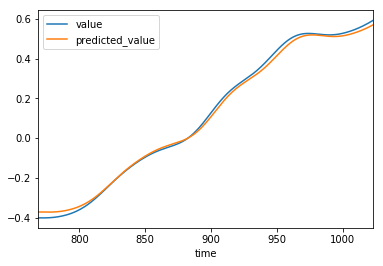

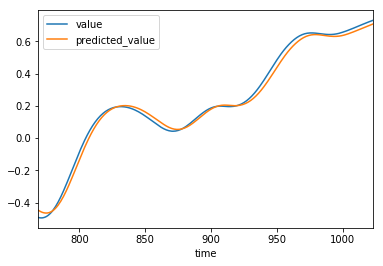

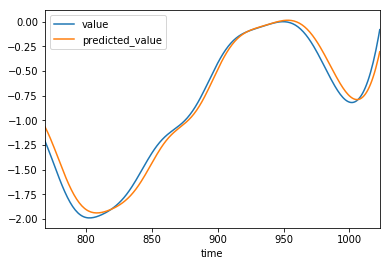

In [23]:
graph_predictions(pts[pts.time > tr_time-tr_time/6], size=5)

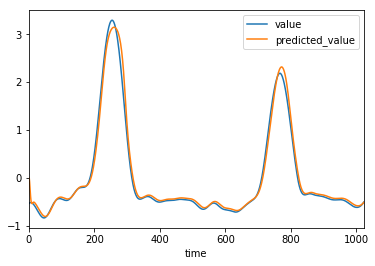

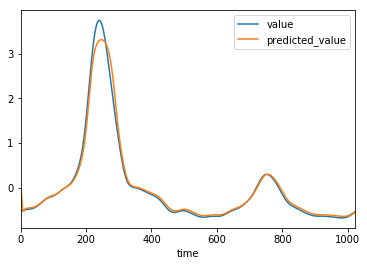

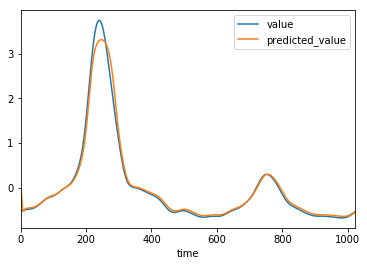

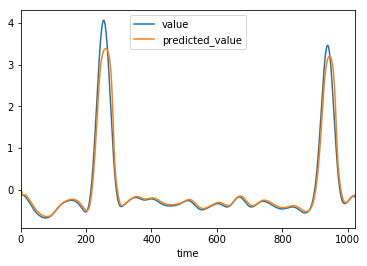

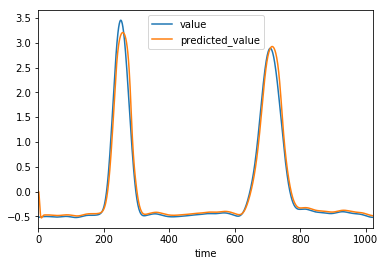

In [24]:
graph_predictions(pts[pts.id > tr_obs], size=5)

## Phase Three: Classifier and ULMFiT approach
First we define our classification dataset and basic classifier architecture. Notice the classifier shares with the language-model that it has encode module as well as cores module. The ULMFiT approach basically entails the following: if we have a strong language-model (NLP) or forecaster (time-series) then initializing our classifiers encoder and cores with the weights from that models encoder and cores can (i) decrease training time considerably (ii) result in a much stronger ultimate accuracy. This pretty much pre-supposes that your LM/forecaster was working well to begin with. So in this section we train a classifier without initializing the weights with our LM, then re-instantiate him and go again with the ULMFiT approach to see if it was helpful!

Quick comment on the 'weights' we use in our cross-entropy loss: a lot of these datasets I have noticed have uneven class distribution which makes training a classifier hard, but on top of that they have small data. Taken together this can make the task very challenging. You can tackle this in two ways: (i) by weighting the loss function (for example if you have 10% class 0, 90% class 1, setting the weights to [0.9, 0.1] should help your loss as well as accuracy) I have set the weight to be symmetric for now. (ii) You can increase your prediction threshold (use fastai.metrics.accuracy_thresh for monitoring this very easily). Basically you tell your model I want you to predict class 1 only if you are >x% sure, where x is usually 50, but increasing this will make it less likely to predict 1 (hence more for 0) and so false negatives and true negatives will both go up.

In [26]:
class cls_ds(Dataset):
    def __init__(self, ts):
        self.x = torch.stack([torch.Tensor(ts.iloc[k][:-1].values.astype('float')) for k in range(ts.shape[0])], dim=1)
        self.y = torch.stack([torch.Tensor([ts.iloc[k].values[-1].astype('int')]).long() for k in range(ts.shape[0])], dim=0)
        self.empty_val = None
    def __len__(self):
        return self.x.size(1)
    
    def __getitem__(self, idx):
        return self.x[:,idx].unsqueeze(1), self.y[idx].squeeze()
    
class clsf(nn.Module):
    def __init__(self, n_in, nh, n_out, ncl, dp, pool=False, lm=None):
        super().__init__()
        self.encode = nn.LSTM(n_in,nh, batch_first=True)
        self.cores = nn.ModuleList([nn.LSTM(nh, nh, batch_first=True) for _ in range(ncl)])
        self.drops = nn.ModuleList([rnn_dropout(dp) for _ in range(ncl)])
        self.pool = pool
        if pool:
            self.decode, self.out = nn.Linear(3*nh, int(nh/2)), nn.Linear(int(nh/2), n_out)
        else:
            self.decode, self.out = nn.Linear(nh, int(nh/2)), nn.Linear(int(nh/2), n_out)
        if lm is not None:
            self.encode.load_state_dict(lm.encode.state_dict())
            for new_core, old_core in zip(self.cores, lm.cores):
                new_core.load_state_dict(old_core.state_dict())
    
    def Pool(self, x, is_max=False):
        f = F.adaptive_max_pool1d if is_max else F.adaptive_avg_pool1d
        return f(x.permute(0,2,1),1).view(x.size(0),-1)
    
    def forward(self, x):
        x = self.encode(x)[0]
        for core, drop in zip(self.cores, self.drops):
            x = drop(core(x)[0])
        if self.pool:
            max_pool = self.Pool(x, is_max=True)
            avg_pool = self.Pool(x)
            x = torch.cat([x[:,-1,:], max_pool, avg_pool], dim=1)
        else:
            x = x[:,-1,:]
        x = self.out(F.relu(self.decode(x), inplace=True))
        return x

In [27]:
df = df.sample(len(df), replace=False)
num_tr = int(np.floor(df.shape[0] * 0.85))
num_classes = df.target.nunique()

In [28]:
tr_data = cls_ds(df.iloc[:num_tr])
val_data = cls_ds(df.iloc[num_tr:])

In [29]:
tr_dl = DataLoader(tr_data, batch_size=16, shuffle=True)
val_dl = DataLoader(val_data, batch_size=16, shuffle=True)

In [30]:
weights = torch.Tensor([1/num_classes for x in range(num_classes)])
clf_net = clsf(n_in = 1, nh = 256, n_out=num_classes, ncl=3, dp=0.0, pool=True, lm=None)
md = fastai.basic_data.DataBunch(tr_dl,val_dl)
crit = nn.CrossEntropyLoss(weights.cuda())
clf_learn = fastai.basic_train.Learner(md, clf_net, loss_func=crit, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


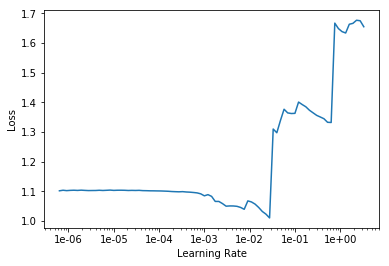

In [31]:
clf_learn.lr_find(); clf_learn.recorder.plot()

In [32]:
clf_learn.fit_one_cycle(3, max_lr = 3e-3)

epoch,train_loss,valid_loss,accuracy
1,0.826566,0.668526,0.840000
2,0.515727,0.361016,0.853333
3,0.409256,0.350068,0.853333


In [ ]:
clf_learn.model.cpu()
get_cm(clf_learn, val_dl)

In [33]:
clf_net_2 = clsf(n_in = 1, nh = 256, n_out=num_classes, ncl=3, dp=0.0, pool=True, lm=lm_net)
clf_learn_2 = fastai.basic_train.Learner(md, clf_net_2, loss_func=crit, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


(None, None)

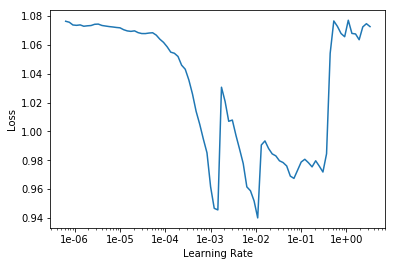

In [34]:
clf_learn_2.lr_find(), clf_learn_2.recorder.plot()

In [35]:
clf_learn_2.fit_one_cycle(3, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy
1,0.591633,0.440812,0.846667
2,0.450342,0.351075,0.853333
3,0.395541,0.325646,0.860000


In [36]:
clf_learn_2.model.cpu()
get_cm(clf_learn_2, val_dl)

array([[90,  0,  0],
       [21,  0,  0],
       [ 0,  0, 39]])

We notice the model has completely correctly learned to segregate class one and three, though fails to distinguish one and two entirely. We also note that the unsupervised pre-training assists in training time as well as ultimate loss/accuracy. Fiddling with the loss function weights can help prioritize class two being classified correctly. 